<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/facenet_1vs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.8 MB/s eta 0:00:00


In [12]:
from sklearn.datasets import fetch_lfw_pairs
from facenet_pytorch import InceptionResnetV1
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [ ]:
lfw_pairs_train = fetch_lfw_pairs(subset='train', color=True)
lfw_pairs_train.pairs.shape

(2200, 2, 62, 47, 3)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet = InceptionResnetV1(pretrained='vggface2').to(device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Two image is Same person, score = 0.7937988638877869


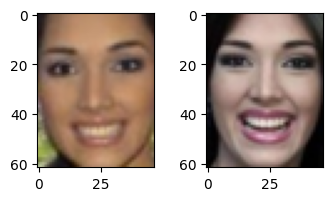

Two image is Same person, score = 0.8003252148628235


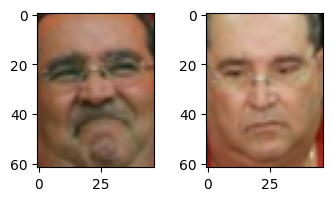

Two image is Same person, score = 0.773360550403595


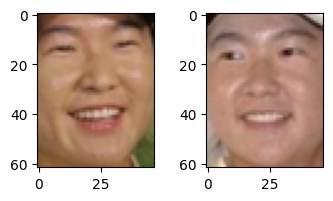

Two image is Same person, score = 0.7603309750556946


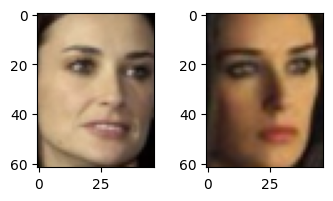

Two image is Same person, score = 0.7333583831787109


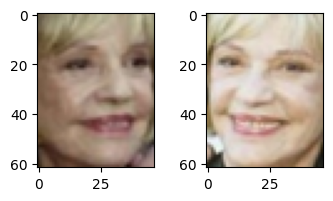

Two image is Same person, score = 0.7077455520629883


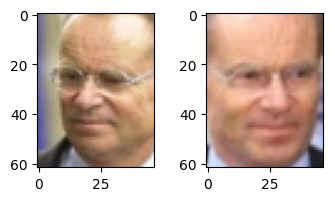

Two image is Same person, score = 0.7651121616363525


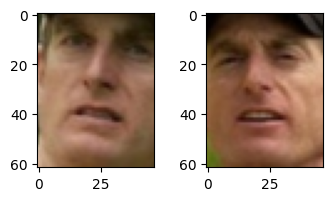

Two image is Same person, score = 0.6739692687988281


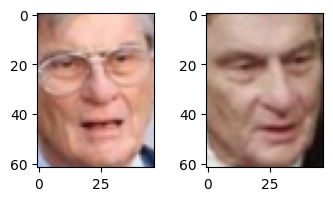

Two image is Same person, score = 0.8301430940628052


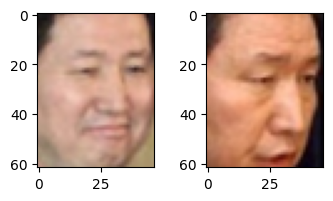

Two image is Same person, score = 0.8841709494590759


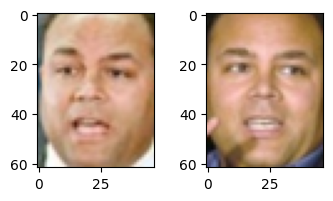

Two image is Same person, score = 0.5120506286621094


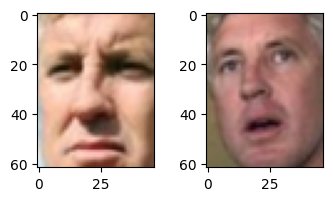

Two image is Same person, score = 0.8324909210205078


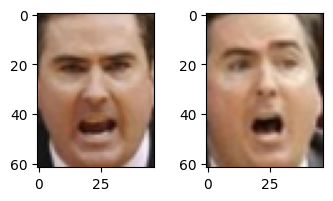

Two image is Same person, score = 0.643282949924469


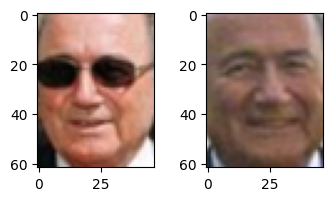

Two image is Same person, score = 0.7399358153343201


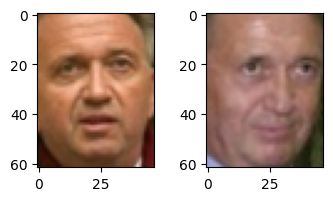

Two image is Same person, score = 0.5777329206466675


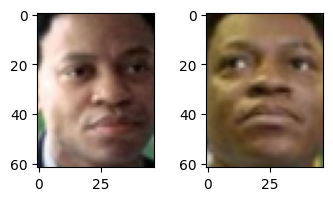

Two image is Different persons, score = -0.1606471836566925


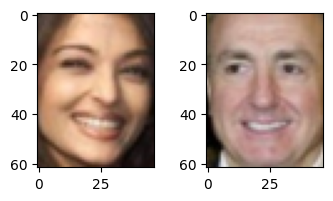

Two image is Different persons, score = 0.21524572372436523


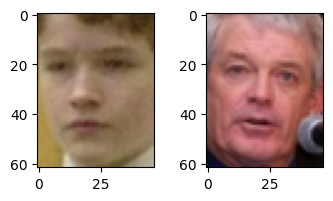

Two image is Different persons, score = -0.056312445551157


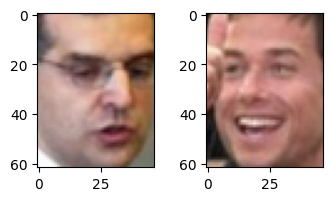

Two image is Different persons, score = -0.020626984536647797


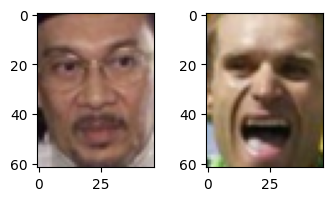

Two image is Different persons, score = -0.029038134962320328


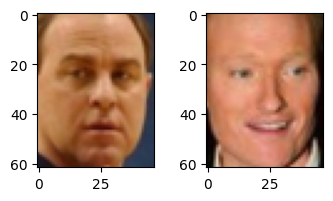

Two image is Different persons, score = 0.17345964908599854


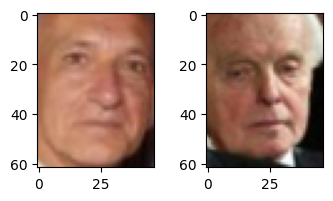

Two image is Different persons, score = 0.0676952600479126


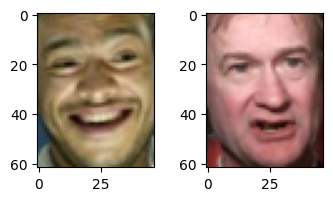

Two image is Different persons, score = 0.28238797187805176


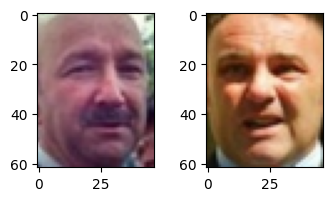

Two image is Different persons, score = 0.0748906061053276


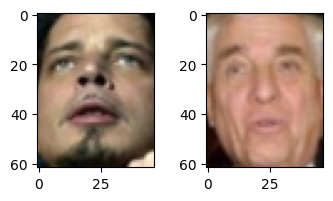

Two image is Different persons, score = 0.2774048149585724


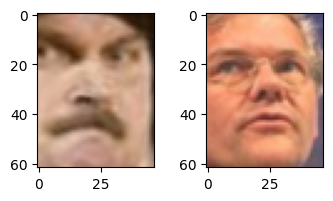

Two image is Different persons, score = -0.1411895751953125


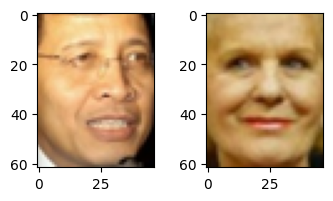

Two image is Different persons, score = -0.018882934004068375


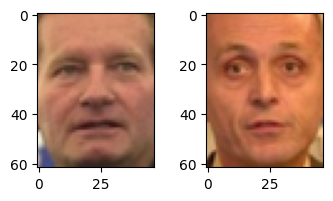

Two image is Different persons, score = 0.07644012570381165


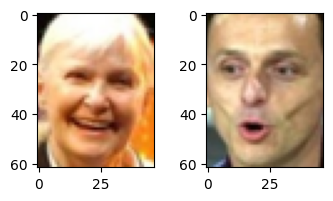

Two image is Different persons, score = 0.011166755110025406


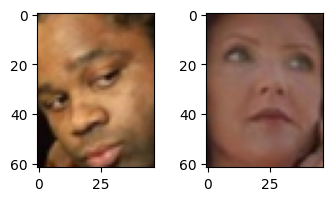

Two image is Different persons, score = -0.037024132907390594


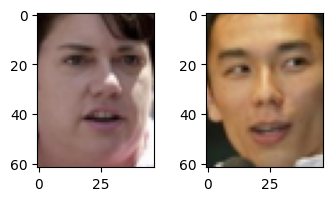

Two image is Different persons, score = 0.033329468220472336


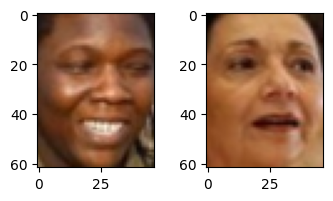

In [ ]:
for img, label in zip(lfw_pairs_train.pairs, lfw_pairs_train.target):
  if random.random() < 0.99: continue
  img0 = img[0]
  img1 = img[1]
  fig = plt.figure(figsize=(4, 2))
  fig.add_subplot(1, 2, 1)
  plt.imshow(img0)
  fig.add_subplot(1, 2, 2)
  plt.imshow(img1)

  img0 = torch.tensor(img0).permute(2, 0, 1)
  img1 = torch.tensor(img1).permute(2, 0, 1)
  img0 = resize(img0, size = (160, 160))
  img1 = resize(img1, size = (160, 160))
  with torch.no_grad():
    vec0 = resnet(img0.unsqueeze(0).to(device))[0].detach().cpu()
    vec1 = resnet(img1.unsqueeze(0).to(device))[0].detach().cpu()
  score = torch.dot(vec0, vec1)

  print(f"Two image is {lfw_pairs_train.target_names[label]}, score = {score}")
  plt.show()


In [ ]:
scores = []

with tqdm(total=len(lfw_pairs_train.pairs)) as pbar:
  for img, label in zip(lfw_pairs_train.pairs, lfw_pairs_train.target):
    img0 = img[0]
    img1 = img[1]

    img0 = torch.tensor(img0).permute(2, 0, 1)
    img1 = torch.tensor(img1).permute(2, 0, 1)
    img0 = resize(img0, size = (160, 160))
    img1 = resize(img1, size = (160, 160))

    with torch.no_grad():
      vec0 = resnet(img0.unsqueeze(0).to(device))[0].detach().cpu()
      vec1 = resnet(img1.unsqueeze(0).to(device))[0].detach().cpu()
    score = torch.dot(vec0, vec1)

    scores.append(score)
    pbar.update(1)


  0%|          | 0/2200 [00:00<?, ?it/s]

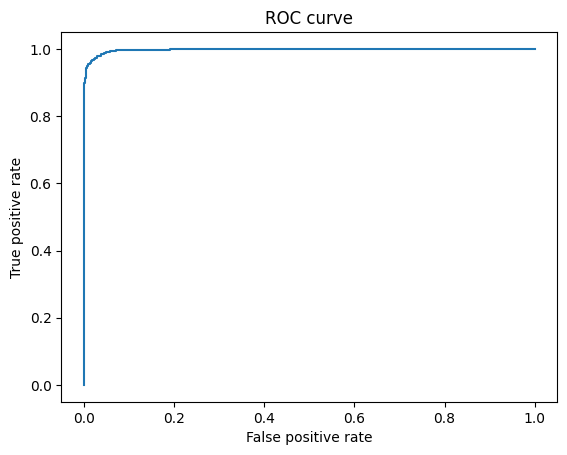

AUC = 0.998


In [ ]:
y_true = lfw_pairs_train.target
y_score = (np.array(scores)+1)/2 # -1~1を0~1に変換
fpr, tpr, threshold = roc_curve(y_true, y_score, pos_label=1)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
print(f"AUC = {roc_auc_score(y_true, y_score):.3f}")

In [ ]:
# https://qiita.com/kotai2003/items/3ee12b776ee205b7db42
precision, recall, threshold_from_pr = precision_recall_curve(y_true, y_score)
a = 2* precision * recall
b = precision + recall
f1 = np.divide(a,b,out=np.zeros_like(a), where=b!=0)
idx_opt = np.argmax(f1)
threshold_opt = threshold_from_pr[idx_opt]
print(f"Threshold = {threshold_opt:.3f}")

Threshold = 0.713


In [ ]:
acc = sum((y_score > threshold_opt)&(y_true == 1)|(y_score <= threshold_opt)&(y_true == 0))/len(y_true)
print(f"Accuracy = {acc:.3f}")

Accuracy = 0.975


# カメラキャプチャ

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [15]:
from facenet_pytorch import InceptionResnetV1, MTCNN
device = "cuda" if torch.cuda.is_available() else "cpu"
mtcnn = MTCNN(image_size=160, margin=10, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').to(device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [16]:
import PIL.Image as Image
filename = 'photo.jpg'
img = Image.open(filename)
img_cropped = mtcnn(img, save_path=filename)
ref = resnet(img_cropped.unsqueeze(0).to(device))[0].detach().cpu()

## 撮影

In [ ]:
from IPython.display import Image
try:
  filename = take_photo("check.jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [25]:
import PIL.Image as Image
filename = 'check.jpg'
img = Image.open(filename)
img_cropped = mtcnn(img, save_path=filename)
vec = resnet(img_cropped.unsqueeze(0).to(device))[0].detach().cpu()
score = torch.dot(ref, vec)
print(score)

tensor(0.8124)
